## loading the data and packages

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime as dt


import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix


In [26]:
# data = pd.read_csv('bank_transactions.csv', delimiter = ',') # original csv

In [2]:
# loading dataframes and concatenating
data_20 = pd.read_csv('twenty_params_2.csv', delimiter = ',')#.drop(['Unnamed: 0'], axis = 1)
data_7 = pd.read_csv('seven_params_3.csv', delimiter = ',').reset_index(drop=True)
data_27 = pd.concat([data_20, data_7], axis = 1)
data_27.set_index('CustomerID', inplace = True)

In [3]:
# fill NA cells with 0 & replace inf values with 0
data_27.fillna(0, inplace = True)
data_27.replace([np.inf, -np.inf], 0, inplace=True)

In [4]:
# for now selecting only numerical values
cols_for_norm = data_27.columns[0:28]
data_num = data_27[cols_for_norm]
data_num.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,TransactionAmount_INR,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,2,28.0,0.074556,0.002962,2,2.0,2553.0,76340.635,73787.635,0
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,1,22.0,0.061931,0.061931,1,1.0,1499.0,24204.490,22705.490,1
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,2,27.0,0.016472,0.001545,2,2.0,727.5,100112.950,99385.450,0
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,1,26.0,0.060462,0.060462,1,0.0,30.0,496.180,466.180,0
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,1,51.0,0.057433,0.057433,1,1.0,5000.0,87058.650,82058.650,1


## 2.2 Choose your features (variables)!

### Data Normalization
The initial data contains both continuous and discrete features which implies that the features variances may be of very different scales. We conduct a dimensionality reduction by PCA and want to obtain dimensions that retain information from both feature types.
If this step is not conducted a PCA to a single dimension will already retain 80% of variance. To illustrate we plot below the PCA of unnormalized data projected into the space of the first two principal components (3 in total). Clustering with k = 5 is conducted and the centroids shown as 'x'

Text(0.5, 1.0, 'k = 5 for unnormalized data')

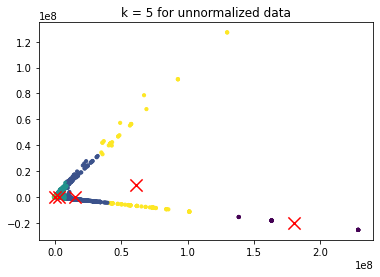

In [23]:
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data_notnorm = pca.fit_transform(data_num)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data_notnorm)

plt.scatter(pca_data_notnorm[:, 0], pca_data_notnorm[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for unnormalized data')

Using sklearn.preprocessing functions, we preprocess the data.

In [5]:

stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)

minmaxScaler = MinMaxScaler()
maxScaler = MaxAbsScaler()
powerScaler = PowerTransformer() #  diffbalsnce!
robScaler = RobustScaler()
normScaler = Normalizer()


cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance',  '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio','mean_diff',]
cols_for_norm = [ 'max_ratio','mean_ratio', 'min_trans','mean_diff', 'diff_balance', 'mean_age_trans', 'min_balance', ]
#cols_for_norm = [ 'max_ratio','mean_ratio', 'min_trans', 'max_trans', 'TransactionAmount_INR', 'diff_balance', 'mean_age_trans','mean_trans', 'mean_balance',  '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']


In [6]:
data_norm = data_num.copy() # 

data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
data_norm[cols_for_fct_scaling] = fctScaler.transform(data_norm[cols_for_fct_scaling])
data_norm[cols_for_pow_scaling] = powerScaler.fit_transform(data_norm[cols_for_pow_scaling])
data_norm[cols_for_norm] = normalize(data_norm[cols_for_norm])

In [7]:
data_norm.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,TransactionAmount_INR,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,-0.015200,0.469705,2.0,2.0,8.203167,7.283105,1.0,0.999255,11.696759,0.012369,...,2,-0.029781,-0.014714,-0.000744,2,1.906793,7.845416,11.242974,0.001134,0
C1010012,0.003568,-0.020811,1.0,1.0,7.313220,7.313220,1.0,0.994686,10.094335,-0.006337,...,1,-0.099152,-0.023833,-0.000761,1,0.102428,7.313220,10.094335,-0.012126,1
C1010014,-0.016632,-0.065171,2.0,2.0,6.874457,6.193895,1.0,0.997237,11.994424,0.019590,...,2,-0.040222,-0.056508,-0.000730,2,1.906793,6.590988,11.514064,0.006837,0
C1010018,-0.034177,-0.242457,0.0,1.0,3.433987,3.433987,1.0,0.994246,6.208952,-0.010298,...,1,-0.086763,-0.040427,-0.001236,1,-1.701937,3.433987,6.208952,-0.032212,0
C1010024,0.054237,0.507426,1.0,1.0,8.517393,8.517393,1.0,0.977403,11.374349,-0.005526,...,1,0.202848,-0.023589,-0.000664,1,0.102428,8.517393,11.374349,0.002725,1


In [ ]:
'''
# TODO these are combinations i tried, all quite bad !
cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']


cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans','mean_ratio' ,'mean_trans', 'mean_balance','TransactionAmount_INR',  'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans']
cols_fro_minmax_scaling = ['min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']

cols_for_std_scaling = [ 'TransactionAmount_INR',  'diff_balance', ]
cols_for_fct_scaling = [ 'min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_trans', 'mean_balance', 'mean_diff','mean_ratio','mean_age_trans']
cols_for_pow_scaling = [  'max_ratio']


cols_for_std_scaling = ['0.75_quant_trans', '0.25_quant_trans',  'diff_balance', 'mean_diff',  'trans_val_var', 'mean_ratio']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance', 'TransactionAmount_INR','min_trans', 'max_trans', 'min_balance','mean_age_trans' ]
#cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_ratio', 'diff_balance', 'mean_diff', 'max_ratio'] 
cols_for_max_scaling = [ 'max_balance','max_ratio', ]


# TODO: former combinations !select better option
stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
minmaxScaler = MinMaxScaler()
powerScaler = PowerTransformer() #  diffbalsnce!

cols_for_std_scaling = [ 'TransactionAmount_INR', 'mean_balance', 'mean_diff', 'diff_balance']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans', 'mean_ratio']
cols_for_pow_scaling = []
cols_for_minmax_scaling = ['min_trans', 'max_trans', 'max_ratio','min_balance', 'max_balance','mean_trans'] #'mean_age_trans'



cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']



cols_for_std_scaling = [ 'diff_balance', 'mean_ratio', 'max_ratio', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff']
cols_for_fct_scaling = ['min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']


'''

Our goal is to observe some clustering of data points when projecting them into the space of principal components. The scaling of the data was conducted by trial and error more or less, trying to obtain some separation of data points. We try to reduce the variability of features that we term less indicatory, for example min_ratio (min ratio of transaction amount to account balance ) whereas we would want to set larger focus on the age of the bank account users. 

We conduct the same illustration as above for normalized data: Do a principal component analysis with n_components = 3 and cluster the data with k = 5 centroids.

Text(0.5, 1.0, 'k = 5 for normalized data')

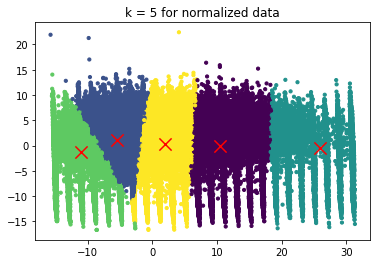

In [91]:
pca = PCA(n_components=0.85) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for normalized data')

### Dimensionality Reduction
The dimensionality is reduced using sklearns PCA method. The number of dimensions is chosen such that > 85 % of the total data variance is retained.

In [8]:
# use sklearn pca to transform the data
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm) # back to data_num from data_norm because kmeans says 0 vectors, no! my fault
print(pca_data.shape)

sparse_pca_data = csr_matrix(pca_data)

(839081, 3)


In [9]:
pca_data.var()
pca.explained_variance_

array([97.47960051, 12.98559812,  7.06394853])

The dataset is reduced to 3 dimensions, which makes computation much more feasible. <br />
<br />
Features variances define how strongly they're represented in the pca output, resulting for a weighting by importance.<br />
<br />
There is always some risk of loosing valuable information when focusing only on the parameters of high variance. Additionally the variance of our data will strongly depend on the normalization previously conducted on it, a factor that will bias the output. <br />
<br />
By introducing a new set of dimensions, the datas space can no longer be interpreted to correspond with the original data parameters.

## 2.3 Clustering!

In [10]:
## matteos first implementation, with mapping and reducing 
# TODO: improve first part

def findNearCentroid(row): # map
    dist = np.sum((centroids_hist[iter]-data[row])**2, axis=1)
    closest = np.argmin(dist)
    return(closest,row) # opposite wont work


def makeNewCentroids(assigned): #shuffle in sense that all centroids are grouped together and reduce by calculating new centroids from data
    shuffled = {}
    #fill_dict =  lambda k, v : shuffled.setdefault(k, []).append(v)
    #map(lambda x: fill_dict(x[0],x[1]), assigned)
    for e in assigned:
        try:
            shuffled[e[0]].append(e[1])
        except:
            shuffled[e[0]] = [e[1]]

    centroids = map( lambda rows: np.mean(data[rows], axis = 0), shuffled.values())
    new_centroids = np.array(list(centroids))
    return (shuffled, new_centroids)

    

def kmeans(k, data, maxIter):
    centroids = np.random.randint(0, data.shape[0], k)
    
    global centroids_hist
    centroids_hist = np.zeros((maxIter+1, k, data.shape[1]), dtype=float)
    centroids_hist[0]= data[centroids]

    rows = np.arange(0, data.shape[0])

    global iter 
    iter = 0

    converge = False

    while tqdm(iter < maxIter and not converge):
        centroids = centroids_hist[iter]
        assigned = map(findNearCentroid, rows) # mapping
        # cp_assigned = [el for el in assigned] # cant copy or modify map object 'assigned' or is empty when passed to makeNewCentoids
        # so access in 

        shuffled, new_centroids = makeNewCentroids(assigned) # shuffling and reducing
        centroids_hist[iter+1] = new_centroids ## fails at times

        if iter > 0 and np.array_equal(centroids_hist[iter],centroids_hist[iter+1]):
             converge = True
             
        iter +=1

    return centroids_hist, shuffled


### Optimal Number of Clusters 
We run the clustering algorithm with n_clusters set in the range [1,10]

#### Elbow Method
Plotting the sum of square distances of data to closest centroid versus the number of centroids.

In [97]:
var = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
    kmeans.fit(sparse_pca_data)
    var.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow method for ideal # clusters')

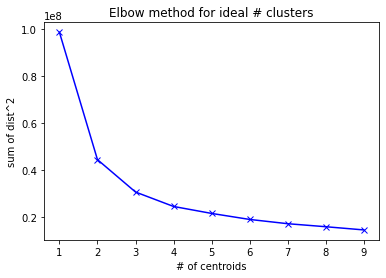

In [98]:
plt.plot(np.arange(1,10), var, 'bx-')
plt.xlabel('# of centroids')
plt.ylabel('sum of dist^2')
plt.title('Elbow method for ideal # clusters')

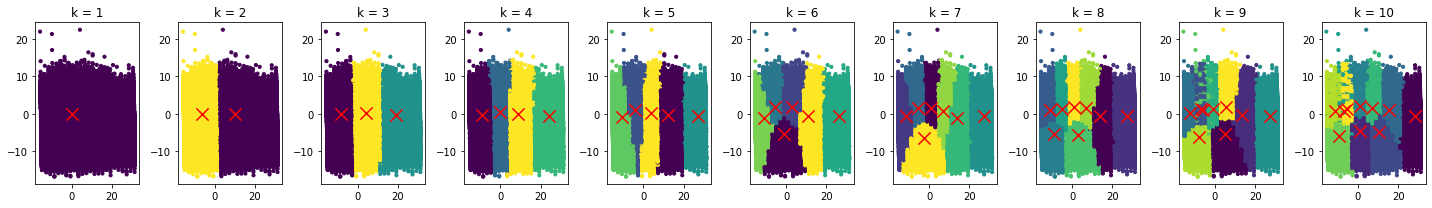

In [99]:

fig,ax = plt.subplots(1,10, figsize = (20,3))

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
    kmeans.fit(sparse_pca_data)

    cmap = plt.cm.get_cmap('jet', i)

    ax[i-1].scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

    centroids = kmeans.cluster_centers_
    ax[i-1].scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
    ax[i-1].set_title('k = '+str(i))

fig.tight_layout()

The elbow method indicates that the ideal number of clusters is around 2, with a stretch one might consider 3.
Given the above plot we can not clearly state the ideal number of clusters, there's some more interesting splitting when moving from k=5 to k=6.

### Run the Algorithm
We run our algorithm with k=2 and 25 iterations. The data has shape (839081, 3) and one iteration takes around 10 seconds.

In [11]:
data  = pca_data # 
out = kmeans(2, data, 25)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [12]:
# for each data row (customerID) get cluster centroid, used to plot colors

d = out[1] # dictionary of clusterID : [data rows]
cols = []
for k,v in d.items():
    for x in v:
        cols.append([x,k])

cols = np.array(cols)
cols = cols[cols[:, 0].argsort()][:,1]

# centroids of the last iteration
centroids = out[0][3] 


Text(0.5, 1.0, 'K-means with k = 5')

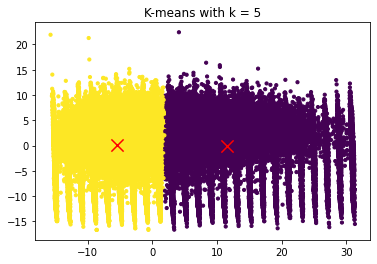

In [13]:
plt.scatter(data[:, 0], data[:, 1], s=10, c = cols)

plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means with k = 5')

### KMeans with scikit-learn Library

Text(0.5, 1.0, 'K-means++ with k = 5')

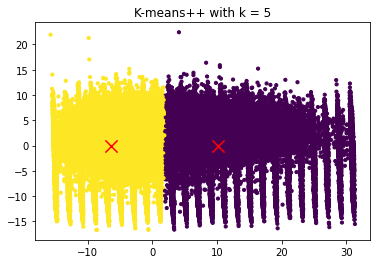

In [14]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means++ with k = 5')

In [ ]:
# TODO: dleete the below plots, this was what i had before, more interesting with k=5 but well

Text(0.5, 1.0, 'K-means with k = 5')

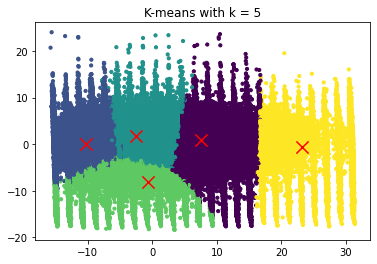

In [300]:
plt.scatter(data[:, 0], data[:, 1], s=10, c = cols)

plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means with k = 5')
# TODO: ! run with higher iteration ? 

Text(0.5, 1.0, 'K-means++ with k = 5')

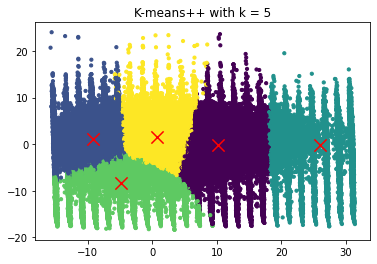

In [301]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means++ with k = 5')

K-means++ clusters similar to our K-means algorithm. There's visibly a slight shifting of cluster centers in the 'purple cluster' but we can not assert this to a difference in the algorithms, since we only run 25 iterations on our algorithms and up to 300 with sklearns k-means++.

## 2.4 Analysing your results!

In [15]:
import math
# function takes a column of the numerical dataframe data_num
# cols is an array of cluster_indexes for each row, as returned by our kmeans algorithm

def make_bins_pv (columns, cols) -> pd.DataFrame:
    mn = min(columns)
    mx = math.ceil(max(columns))
    bins = np.arange(mn, mx, math.ceil((mx-mn)/4) ) # make bins using min, max values of features
    bins = np.append(bins, mx) # append max value to ensure correct format
    cut = pd.cut(x=columns, bins=bins) # categorising data into bins, returns series
    dumm = pd.get_dummies(cut) # make column out of each category
    pv = pd.pivot_table(dumm, index = cols) # build pivot table
    pv.index.name = 'Cluster'
    return pv

### Pivot Tables

In [22]:
col = data_num['mean_trans']
mean_trans = make_bins_pv(col, cols)
mean_trans.style.set_caption('Mean Transaction')

,"(0.0, 390009.0]","(390009.0, 780018.0]","(780018.0, 1170027.0]","(1170027.0, 1560035.0]"
Cluster,,,,
0,0.998694,0.000025,0.000000,0.000003
1,0.999773,0.000019,0.000002,0.000002


In [17]:

col = data_num['trans_greater_1k']
trans_greater_1k = make_bins_pv(col, cols)
trans_greater_1k.style.set_caption('Number of Transactions greater than 1K')

,"(0.0, 2.0]","(2.0, 4.0]","(4.0, 6.0]"
Cluster,,,
0,0.773497,0.008461,0.000040
1,0.846243,0.011250,0.000062


In [18]:

col = data_num['most_freq_hour']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Most Frequent Hour of Transaction')


,"(0, 6]","(6, 12]","(12, 18]","(18, 23]"
Cluster,,,,
0,0.091644,0.540128,0.317932,0.006189
1,0.000000,0.007492,0.434278,0.558230


In [19]:
col = data_num['mean_balance']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Mean Balance')

,"(0.0, 28758874.0]","(28758874.0, 57517748.0]","(57517748.0, 86276622.0]","(86276622.0, 115035496.0]"
Cluster,,,,
0,0.998094,0.000105,0.000031,0.000006
1,0.998124,0.000064,0.000019,0.000012


In [20]:

col = data_num['gender_most_freq']
dumm = pd.get_dummies(col)
pv = pd.pivot_table(dumm, index = cols)
pv.index.name = 'Cluster'
pv.style.set_caption('Most Frequent Gender')

,0,1
Cluster,,
0,0.255508,0.744492
1,0.287970,0.712030


In [21]:

col = data_num['mean_age_trans']
mean_age_trans = make_bins_pv(col, cols)
mean_age_trans.style.set_caption('Mean Age at Transaction')

,"(15.0, 40.0]","(40.0, 65.0]","(65.0, 90.0]","(90.0, 115.0]"
Cluster,,,,
0,0.886273,0.105808,0.007245,0.000567
1,0.895163,0.099369,0.004818,0.000577


### Clustering score Metrics 

In [23]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [24]:
calinski_harabasz_score = calinski_harabasz_score(pca_data, cols)
calinski_harabasz_score

1020249.1008498162

Calinski Harabasz Score = 1020249.1 
The ratio between intracluster disperion and intercluster dispersion.

In [25]:
davies_bouldin_score = davies_bouldin_score(pca_data, cols)
davies_bouldin_score


0.7981477454174393

Davies Bouldin Score = 0.798
The ratio of intracluster distance to intercluster distance is a value within the range (0,1).
<br />
<br />
The high scores are in accordance to what we observe when plotting the two PC or look at the pivot tables. The customers don't cluster into distinct groups and the large number of parameters results in one blob of data, hence the distance between any pair of data points is low.
The most frequent hours seems to be only parameter invetigted that shows to be well separated by clustering.
<br />
<br />
We propose that better clustering would mainly require a suitable normalization of features. Additionally more accurate results could be obtained by using a different clustering algorithm.